# How to create a Saliency Map using saliency_map.py

## Theoretical Background

Saliency_map.py implements a Saliency Map handler to create saliency maps for RNN Encoder-Decoder Load Forecasting Models. 

The input data for the RNN can be imagined as a two-dimensional series image, with the dimensions time and feature. The time dimension is split into the history horizon and the forecast horizon, whereas the features are the different types of input sequences, like "temperature" or "load". Each "pixel" of that series image is a specific value that a certain input feature takes at a certain time step.

The saliency map method uses the method of perturbation to find out which "pixels" are the most important for the model to make a precise forecast. The perturbation is like laying a mask over that input series image. The dimensions of the mask are the same as the dimensions of the series image, which means that there is a corresponding mask value for each "pixel" value. The mask determines which input "pixels" are to be changed, and which ones are not. The mask can take any value between 0 and 1. A mask value of 1 means that the pixel of the original "image" is used, whereas a mask value of zero means that the "pixel" is completely swapped with a reference pixel.

The reference values are determined beforehand, by adding gaussian noise to the original input series. So in other words, the mask value also determines, if the original value is perturbed by noise or not. A low mask value means lots of perturbation, while a high mask value means low to no perutrbation at all.

To find the regions ("pixels") of the input series image, that are the most important for the forecast, an optimization algorithm finds the mask, that when applied to the input series image, minimizes the error between the original prediction (without any perturbation) and the perturbed prediction (with perturbed inputs). 

To only find the very most important "pixels", also called "Smallest Sufficient Region" (SSR), the optimization algorithms also minimizes the mask values, and so forces the mask to have low values. This works by adding another term to the objective function of the optimization problem, which penalized high mask values. That term is then also multiplied by lambda, which is the parameter that determines how much high mask values are penalized. A higher lambda value leads to higher perturbation overall than with a low lambda value.

The end result of the optimization is a two dimensional Time x Feature heatmap, which is also called Saliency Map. The mask values are colour coded, while one is encoded as red, and zero is encoded as blue. In other words, red signifies important features and time steps, while blue signifies, that it's not important for the forecast, wheter or not the parameter is noisy.

## Choosing a target


First of all, the data on which the evaluation should take place has to be chosen. Put your data in the 'proloaf/data' folder. In this example, data from the "open opwer system data" website is used (https://data.open-power-system-data.org/time_series/).

## Train your model

if the model has already been trained and saved, you can skip this step

Create a folder for the model in 'targets' and set the configurations in the "config.json". The example config file looks like this: 

In [9]:
import sys
import os

MAIN_PATH = os.path.abspath(os.path.join('../'))
sys.path.append(MAIN_PATH)
print(f"MAIN_PATH: {MAIN_PATH}")

from proloaf import confighandler as ch

MAIN_PATH: E:\Arbeit\proloaf


In [14]:
import json 

target = 'opsd_example'
config_path = './targets/' + target + '/config.json'
model_config = ch.read_config(
            config_path=os.path.join(MAIN_PATH, config_path),
            main_path=MAIN_PATH
        )

print(json.dumps(model_config, indent = 4))

{
    "data_path": "./data/opsd.csv",
    "output_path": "./oracles/",
    "exploration_path": "./targets/opsd/tuning.json",
    "evaluation_path": "./oracles/eval_opsd_recurrent/",
    "log_path": "./logs/",
    "model_name": "opsd_recurrent_home",
    "target_id": [
        "DE_load_actual_entsoe_transparency"
    ],
    "target_list": null,
    "start_date": null,
    "history_horizon": 147,
    "forecast_horizon": 24,
    "cap_limit": 1,
    "train_split": 0.6,
    "validation_split": 0.8,
    "periodicity": 24,
    "optimizer_name": "adam",
    "exploration": false,
    "cuda_id": null,
    "feature_groups": [
        {
            "name": "main",
            "scaler": [
                "minmax",
                0.0,
                1.0
            ],
            "features": [
                "DE_load_actual_entsoe_transparency",
                "DE_temperature",
                "DE_radiation_direct_horizontal",
                "DE_radiation_diffuse_horizontal"
            ]
     

now train the model using the train.py skript. For more information on how to train a model, take a look at the other notebooks or at the user documentation (http://sogno.energy/proloaf/docs/overview/) 

In [ ]:
!python ./src/train.py -s opsd_example

You should now have a trained model in the "oracles" folder

## configure the saliency map handler

 now the parameters for the saliency map calculation should be configured. The  saliency.json file should be in the targets folder (e.g targets/opsd_example).
 
 The following Parameters can be configured:
 
 - rel_interpretation_path: the path, where the output files are going to be saved to
 - date: The date for which the saliency map should be created. This is the date of the first timestep of the forecasting horizon
 - ref_batch_size: The number of different random noise time series to be added to the original input data. This determines the number of references.
 - max_epochs: The maximum number of epochs for the optimization of the objective function.
 - n_trials: The number of trials of the optuna study. This determines the number of trials with different hyperparameters. The only current hyperparameter is the learning rate of the optimizer.
 - lr_low: The lowest learning rate a study trial can take
 - lr_high The highest learning rate a study trial can take 
 - lambda: the weight that determines the size of the mask weight error. A high lambda value means that high mask values are penalized more in the objective function, so that the mask values turn out to be smaller overall.
 - cuda_id: the cuda id, which determines what cuda device is going to be used for the pytorch module (https://pytorch.org/)
 
 The config file should be in json format and could looks like this:

In [15]:
config_path = './targets/' + target + '/saliency.json'
model_config = ch.read_config(
            config_path=os.path.join(MAIN_PATH, config_path),
            main_path=MAIN_PATH
        )

print(json.dumps(model_config, indent = 4))

{
    "rel_interpretation_path": "oracles/interpretation/",
    "date": "27.07.2019 00:00:00",
    "ref_batch_size": 2,
    "max_epochs": 1,
    "n_trials": 1,
    "lr_low": 1e-06,
    "lr_high": 0.1,
    "lambda": 1,
    "cuda_id": 0
}


# Run the Saliency Map optimizer

Import the Saliency Map Handler class

In [17]:
from proloaf import saliency_map as sm

First an instance of the saliency map handler has to be made. The name of the example target station is opsd_example

In [19]:
saliency_map_handler = sm.SaliencyMapHandler(target)

2022-05-25 19:42:57 - saliency_map - INFO - reading saliency.json config
2022-05-25 19:42:57 - saliency_map - INFO - reading model config...
2022-05-25 19:42:57 - saliency_map - INFO - importing data...
2022-05-25 19:42:57 - saliency_map - INFO - setting computation device...
2022-05-25 19:42:57 - saliency_map - DEBUG - Device: cpu
2022-05-25 19:42:57 - saliency_map - INFO - preparing the dataset...
2022-05-25 19:42:57 - tensorloader - DEBUG - frame not prepared
2022-05-25 19:42:57 - datahandler - INFO - No missing data
2022-05-25 19:42:57 - saliency_map - INFO - loading the forecasting model
2022-05-25 19:42:58 - saliency_map - DEBUG - initializing saliency map...
2022-05-25 19:42:58 - saliency_map - INFO - Date and Time set to: 2019-07-27 00:00:00
2022-05-25 19:42:58 - saliency_map - DEBUG - Timestep for saliency map with the date 2019-07-27 00:00:00 is 40032


Now that we have a class instance, the create_saliency_map() function can be called.

In [20]:
saliency_map_handler.create_saliency_map()

2022-05-25 19:43:18 - saliency_map - INFO - starting timer for proloaf.saliency_map function
2022-05-25 19:43:18 - saliency_map - INFO - creating references...
2022-05-25 19:43:18 - saliency_map - INFO - create saliency map...
2022-05-25 19:43:18 - _in_memory - INFO - A new study created in memory with name: no-name-ea43fe1c-1efe-4a83-8323-cef7f83a65b0
2022-05-25 19:43:32 - saliency_map - DEBUG - epoch 0 / 1 	 epoch loss: 1.728506088256836
2022-05-25 19:43:32 - study - INFO - Trial 0 finished with value: 1.728506088256836 and parameters: {'learning rate': 1.1292119621259929e-05}. Best is trial 0 with value: 1.728506088256836.
2022-05-25 19:43:32 - saliency_map - INFO - proloaf.saliency_map function finished in: 14.16244579999966 seconds


# Useful functions

At any point now the class instance can be saved, so that the results can be loaded again at any point in the future

In [21]:
saliency_map_handler.save()

if you want to load a previously saved class instance call load()

In [25]:
import pandas as pd
date = pd.to_datetime("27.07.2019 00:00:00")
saliency_map_handler = sm.SaliencyMapHandler.load(target, date)

The visualize the result and save a plot, the plot() function should be called. 

2022-05-25 19:46:36 - saliency_map - INFO - creating saliency map plot...
2022-05-25 19:46:38 - saliency_map - INFO - plot saved in E:\Arbeit\proloaf\oracles/interpretation/opsd_example/2019-07-27_heatmap.


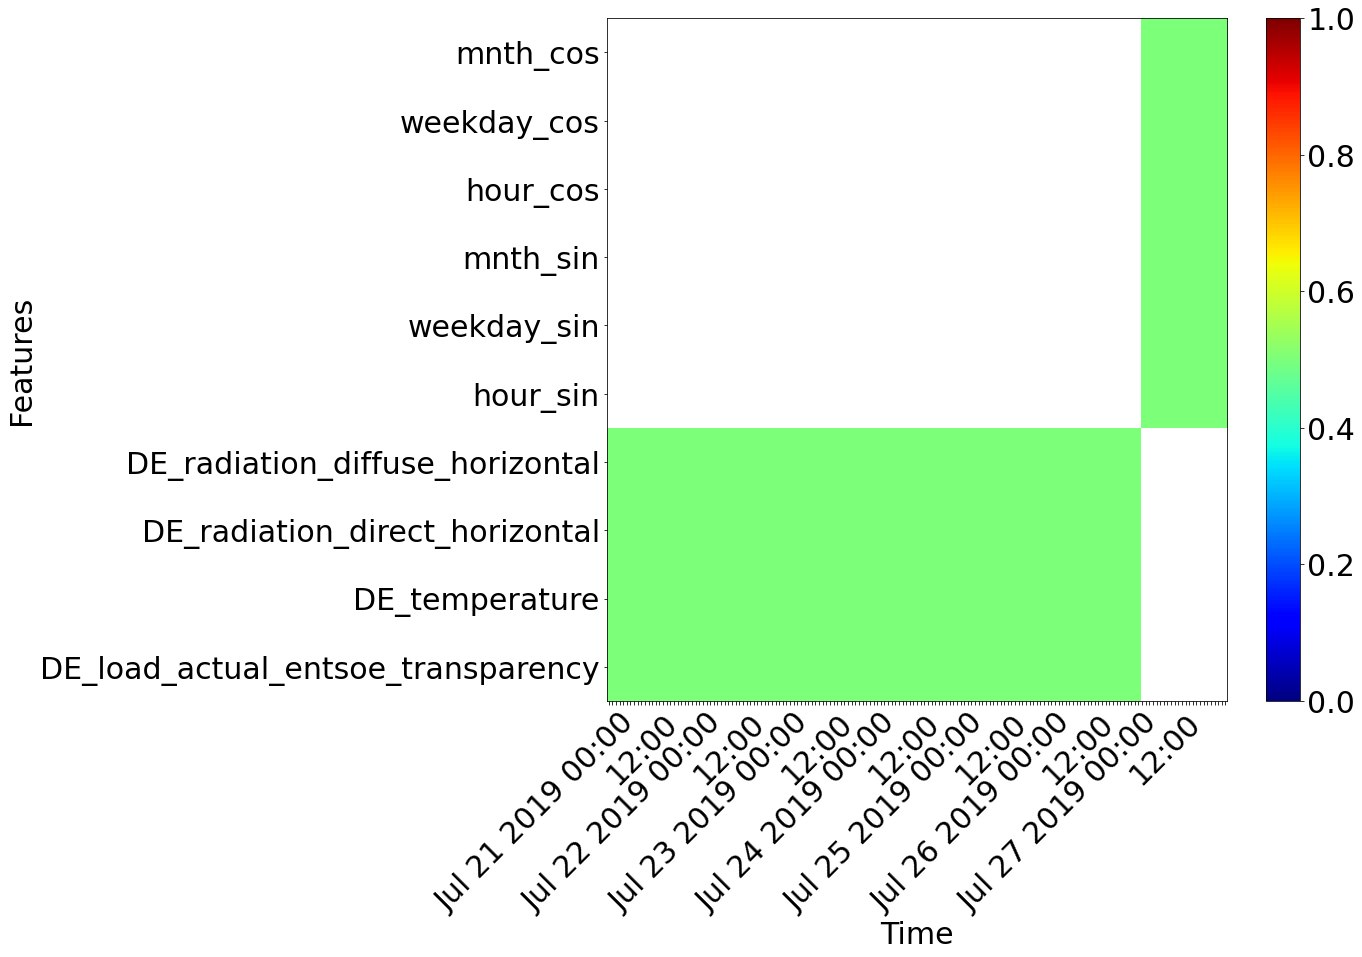

In [26]:
saliency_map_handler.plot()

The Saliency Map is split into the history horizon and the forecast horizon on the time axis. The forecast horizon begins at the exact date and time given in the saliency.json config file. The white spaces in between mean that the feature is not defined for that time period, because some features are only encoder features or only decoder features. Encoder features are only defined for the history horizon, while decoder features are only defined for the forecast horizon. 

The bar at the right side shows the colour coding of the saliency map. Blue values signify that the feature is the most perturbed, while red signifies that the feature is not perturbed at all. Any value in between is a linear function between these two cases. the more red a pixel is, the more important it is for the forecast that the corresponding feature and time step are not noisy, but accurate values. The more blue a pixel is, the less important it is for the forecast that the value is noisy. In other words, red pixels are important and blue pixels not so much.

In this example calculation the epoch is set to one, so the optimization is very bad and the saliency map parameters don't differ very much from their initialization value 0.5. When a calculation is done with a higher epoch value (e.g 3000) the saliency map looks like this: 

![Saliency Map with epochs set to 3000 and lambda set to one](figures/2019-07-27_heatmap_lambda1.png)

If you also want to know how the perturbed prediction performed in comparison to the unperturbed one use plot_predictions()

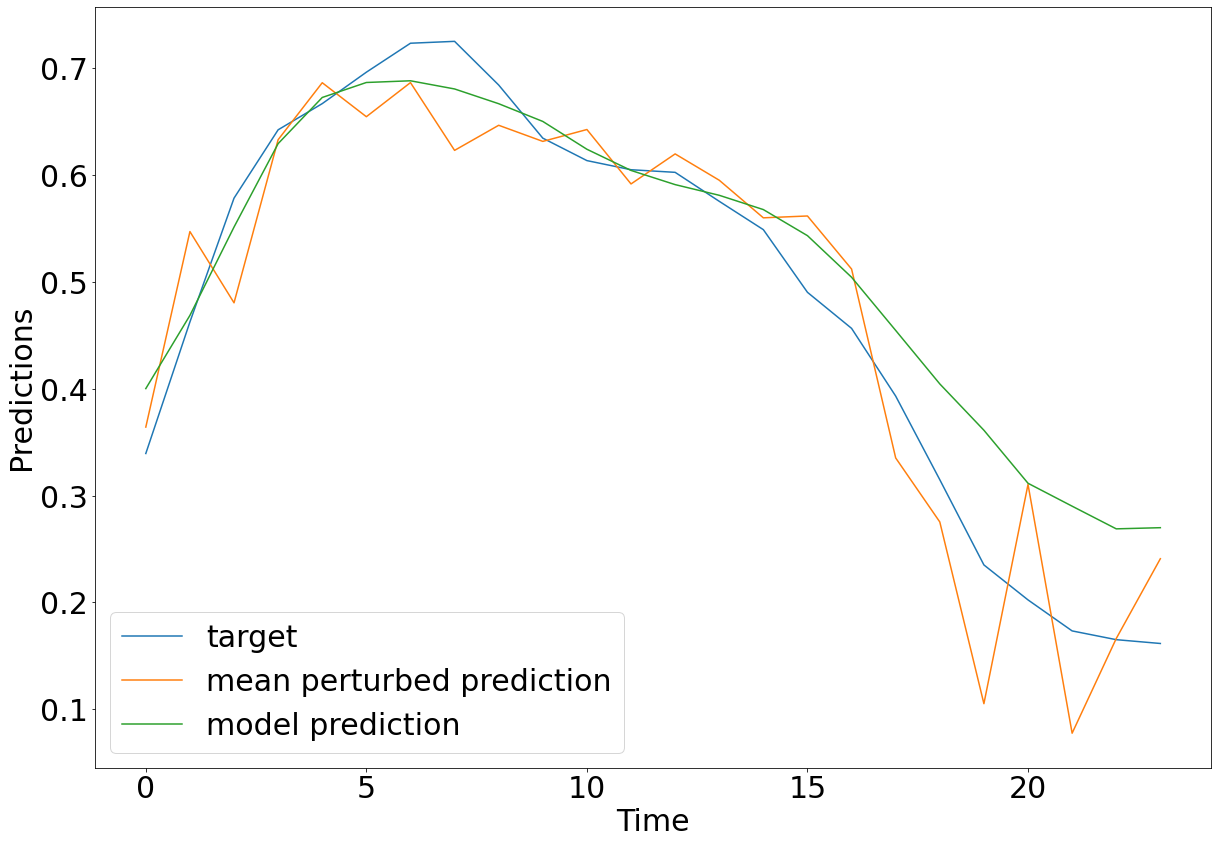

In [27]:
saliency_map_handler.plot_predictions()

The blue line is the target line, which is the raw input data. The green line is the forecast the model makes without any perturbation of the input data. The orange line is the prediction the model makes, when the input data is perturbed by the saliency map.

Specific values of the saliency map are also accessable 

In [28]:
saliency_map = saliency_map_handler.saliency_map
encoder_saliency_map = saliency_map[0]
decoder_saliency_map = saliency_map[1]

Similarly, the tensor of the model prediction can be accessed via:

In [29]:
saliency_map_handler.model_prediction

tensor([[[ 0.4001, -4.9668],
         [ 0.4686, -4.7943],
         [ 0.5513, -4.5741],
         [ 0.6294, -4.3948],
         [ 0.6726, -4.4487],
         [ 0.6866, -4.5928],
         [ 0.6882, -4.6404],
         [ 0.6806, -4.6224],
         [ 0.6668, -4.5623],
         [ 0.6502, -4.4913],
         [ 0.6241, -4.5992],
         [ 0.6043, -4.6884],
         [ 0.5910, -4.7576],
         [ 0.5810, -4.8174],
         [ 0.5677, -4.8880],
         [ 0.5433, -4.9901],
         [ 0.5043, -5.1278],
         [ 0.4546, -5.2815],
         [ 0.4045, -5.4133],
         [ 0.3612, -5.4825],
         [ 0.3115, -5.2749],
         [ 0.2901, -5.0370],
         [ 0.2689, -4.8567],
         [ 0.2699, -4.8417]]])

Also the inputs and references can be accessed via:

In [30]:
encoder_input = saliency_map_handler.encoder_input
encoder_references = saliency_map_handler.encoder_references
decoder_input = saliency_map_handler.decoder_input
decoder_references = saliency_map_handler.decoder_references

To look at the date and time of the class instance use:

In [34]:
date_time = saliency_map_handler.datetime
print(date_time)

2019-07-27 00:00:00


If you want to know the corresponding index of the date in the dataset you can call:

In [36]:
index = saliency_map_handler.time_step
print(index)

40032
